In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit as cf
from scipy.stats import chi2
from math import floor
from scipy.interpolate import UnivariateSpline
import scipy.interpolate as si
from scipy.signal import find_peaks as fpk
from scipy.optimize import curve_fit as cf

In [2]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['font.size'] = 20
mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
plt.rcParams["figure.figsize"] = (11,6)

c_list = ['tab:orange','crimson','forestgreen','darkmagenta','lightseagreen']

In [3]:
def chi2_red(y,y_err,x,func,popt):
    puntos = len(y)
    params = len(popt)
    grados_lib = puntos - params - 1
    y_ajuste = func(x,*popt)
    
    chi_cuadrado = np.sum(((y-y_ajuste)/y_err)**2)
    chi_reducido = chi_cuadrado/grados_lib
    return chi_reducido

def r2(y,x,lineal,pars):
    r2 = 1 - (np.sum((y-lineal(x,*pars))**2)/np.sum((y - np.mean(y))**2))
    return r2

dcmls = lambda x : -int(floor(np.log10(abs(x))))

In [4]:
def interpolation_baby(x,y,interval):
    med_height = (np.max(y)-np.min(y))/2
    spline = UnivariateSpline(x[interval],y[interval]-med_height,s=0)
    x_spline = np.linspace(np.min(x[interval]),np.max(x[interval]),100*len(x[interval]))
    y_spline = spline(x_spline) + med_height
    return x_spline,y_spline

In [5]:
def fufu_ultimate(t_p,p,t_r,r,scale_diff,identifier,i):
    plt.plot(t_p,p/scale_diff,'navy',zorder=2,label=f'pulso/{scale_diff}')
    plt.plot(t_r,r,'crimson',zorder=1,label='respuesta')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud [V]')
    plt.legend()
    plt.grid()
    plt.savefig(f'{identifier}_señales.png')
    plt.show()
    
    fufu0 = np.fft.fft(r)
    len_t = len(t_r)
    dt = np.mean(np.diff(t_r))
    f = np.fft.fftfreq(len_t,dt)
    fufu = np.abs(fufu0)
    f = f[np.arange(len_t//2)]
    fufu = fufu[np.arange(len_t//2)]
    plt.plot(f,fufu,'crimson')
    plt.grid()
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Amplitud [V]')
    plt.savefig(f'{identifier}_fufu.png')
    plt.show()
    
    pk_idx = np.argmax(fufu[1:])
    pk_idx += 1
    pk = f[pk_idx]
    err = (f[pk_idx+1]-f[pk_idx-1])/4
    print(f'Máximo encontrado en ({round(pk)} \u00B1 {round(err)}) Hz')
    intervalo_f = [pk-20*err,pk+40*err]
    plt.plot(f,fufu,'crimson')
    plt.grid()
    plt.xlim(intervalo_f)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Amplitud [V]')
    plt.savefig(f'{identifier}_fufu_zoom.png')
    plt.show()
    
    intervalo_h = np.arange(pk_idx-i//2,pk_idx+i)
    f_spline,fufu_spline = interpolation_baby(f,fufu,intervalo_h)

    
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Amplitud [V]')
    plt.scatter(f[intervalo_h],fufu[intervalo_h],c='navy',label='Transformada',zorder=2)
    plt.plot(f_spline,fufu_spline,'crimson',label='Splines',zorder=1)
    plt.legend()
    plt.grid()
    plt.savefig(f'{identifier}_interp.png')
    plt.show()

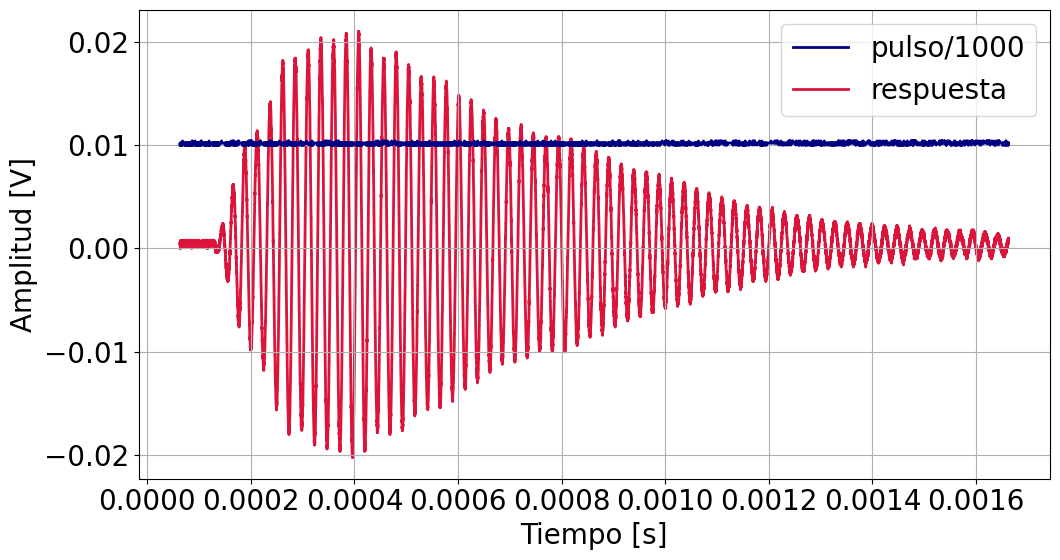

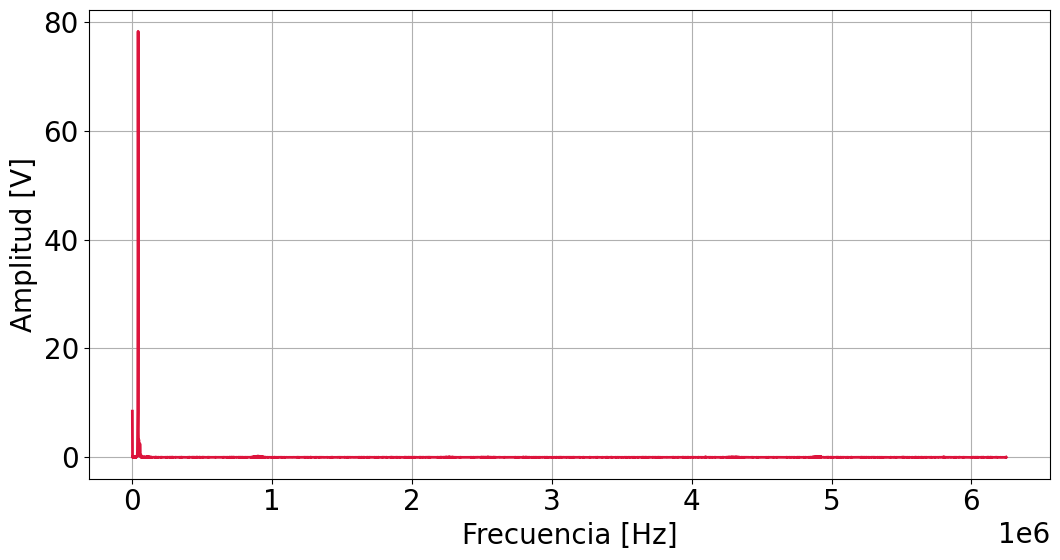

Máximo encontrado en (41250 ± 312) Hz


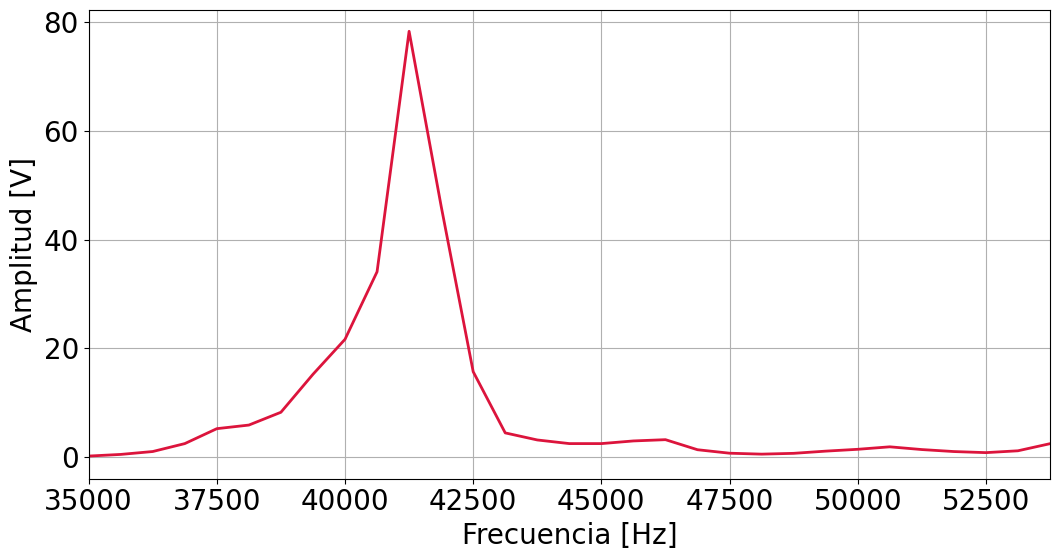

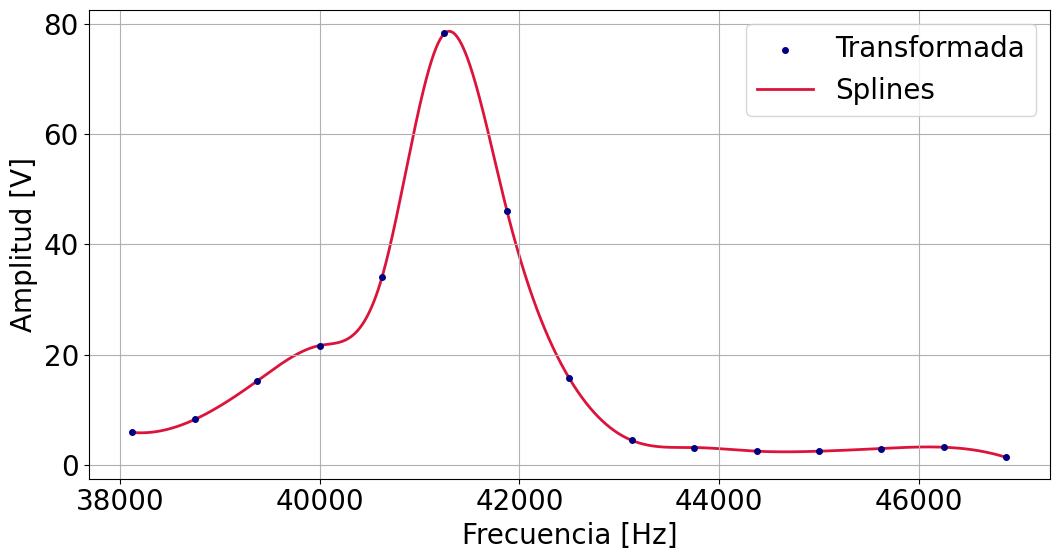

In [6]:
data_p = np.loadtxt('seke+/TEK00004.CSV',delimiter=',',unpack=True,skiprows=16)
t_p,cuad_p,resp_p = data_p
fufu_ultimate(t_p,cuad_p,t_p,resp_p,1000,'c',10)

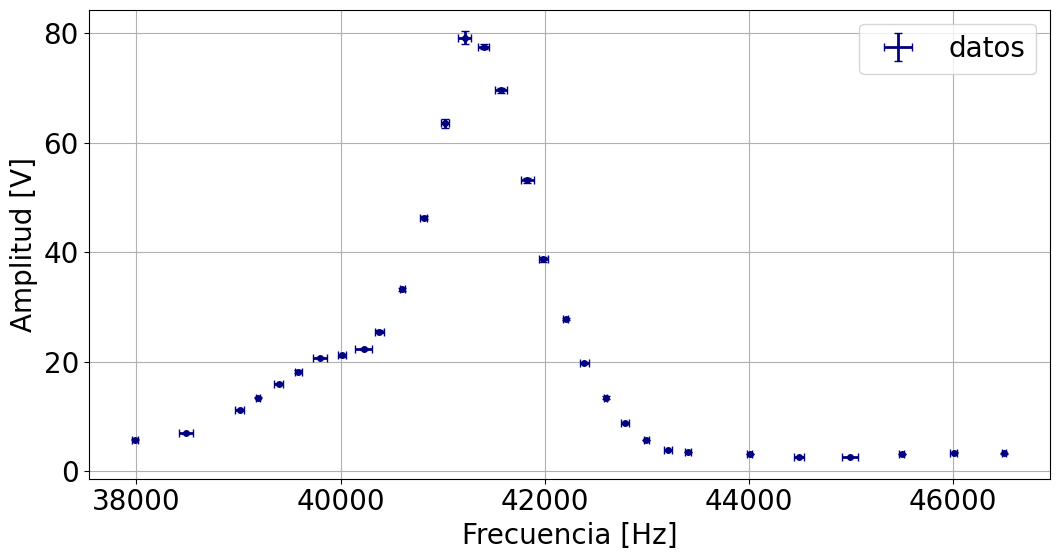

In [7]:
barrido_p = np.loadtxt('seke+/barrido piezos.csv',delimiter=',',unpack=True,skiprows=1)
amp_p = barrido_p[2][4:-5]/20
freq_p = barrido_p[6][4:-5]*1000
err_amp_p = abs(barrido_p[3])[4:-5]/20
err_freq_p = abs(barrido_p[7])[4:-5]*1000

plt.errorbar(freq_p,amp_p,yerr=err_amp_p,xerr=err_freq_p,fmt='None',ecolor='navy',label='datos',zorder=2)
plt.scatter(freq_p,amp_p,c='navy',zorder=3)
plt.grid()
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [V]')
plt.legend()
plt.savefig('campana_piezos.png')

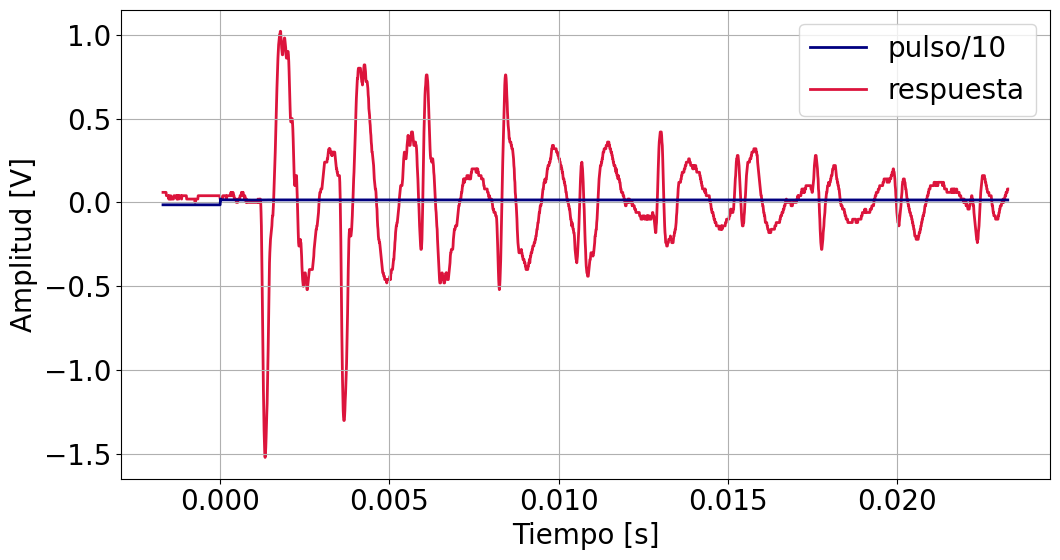

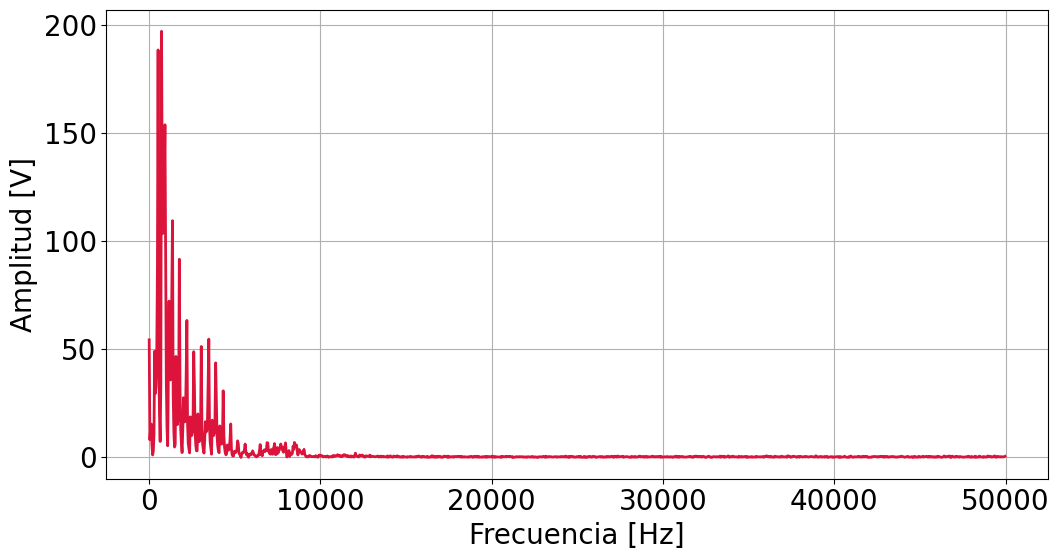

Máximo encontrado en (720 ± 20) Hz


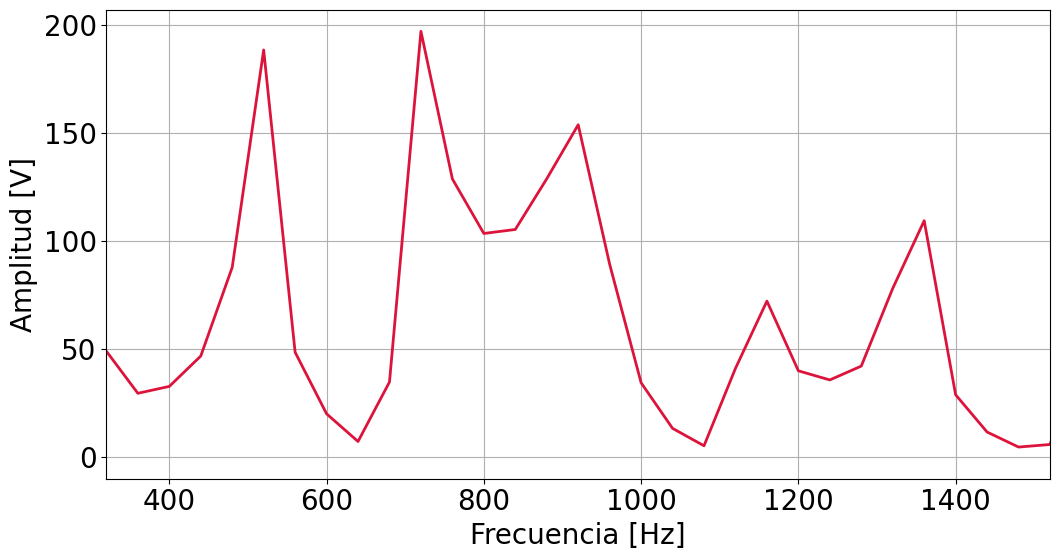

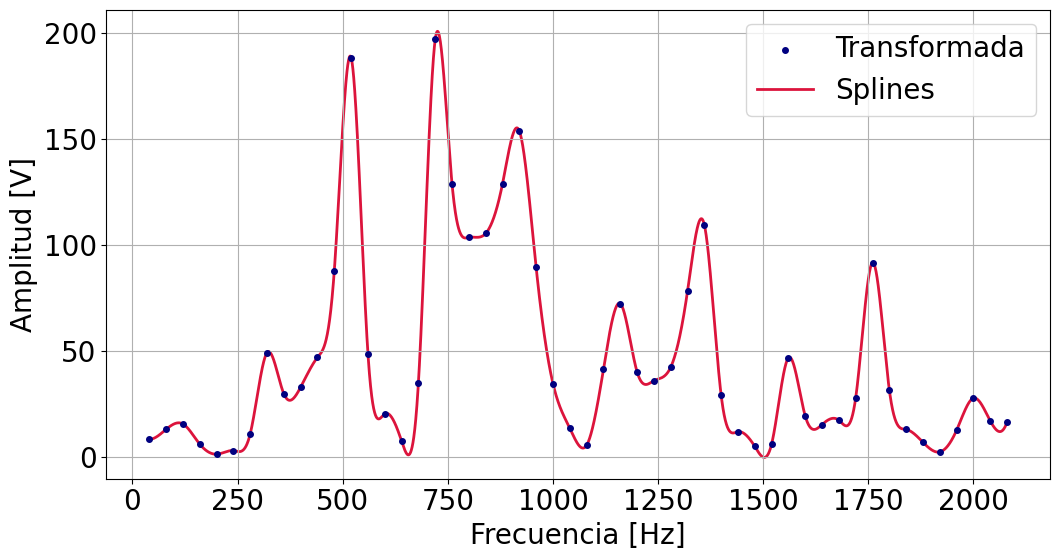

In [8]:
data1_k = np.loadtxt('seke+/cerrado/F0001CH1.CSV',delimiter=',',unpack=True,usecols=[3,4])
x1_k,y1_k = data1_k
data2_k = np.loadtxt('seke+/cerrado/F0001CH2.CSV',delimiter=',',unpack=True,usecols=[3,4])
x2_k,y2_k = data2_k

fufu_ultimate(x2_k,y2_k,x1_k,y1_k,10,'k',35)

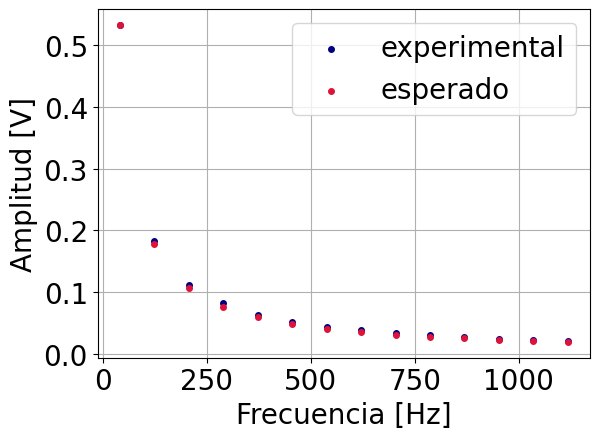

In [9]:
data0 = np.loadtxt('seke+/amp_freq_1.csv',delimiter=',',unpack=True,skiprows=1)
amp0 = data0[2]/2
freq0 = data0[4]
err_amp0 = abs(data0[3])

amp0_t = np.ones_like(amp0)
for i in range(len(amp0_t)):
    amp0_t[i] = amp0_t[i]*amp0[0]/(2*i+1)

plt.figure(figsize=(6.4,4.8))
#plt.errorbar(freq0,amp0,yerr=err_amp0,fmt='None',ecolor='navy',label='experimental',zorder=2)
plt.scatter(freq0,amp0,c='navy',label='experimental',zorder=3)
#plt.errorbar(freq0,amp0_t,yerr=err_amp0,fmt='None',ecolor='crimson',label='teórico',zorder=2)
plt.scatter(freq0,amp0_t,c='crimson',label='esperado',zorder=3)
plt.legend()
plt.grid()
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [V]')
plt.savefig('bn_f.png')
plt.show()
plt.close()

In [10]:
def fufu_sum(t,freq,coef):
    sum = np.zeros_like(t)
    for n in range(len(coef)):
        sum += coef[n]*np.sin(2*np.pi*freq[n]*t)
    return sum

def fufu_sum_teo(t,freq):
    sum = np.zeros_like(t)
    for n in range(len(freq)):
        sum += (1/((2*n+1)))*np.sin(2*np.pi*freq[n]*t)
    return sum

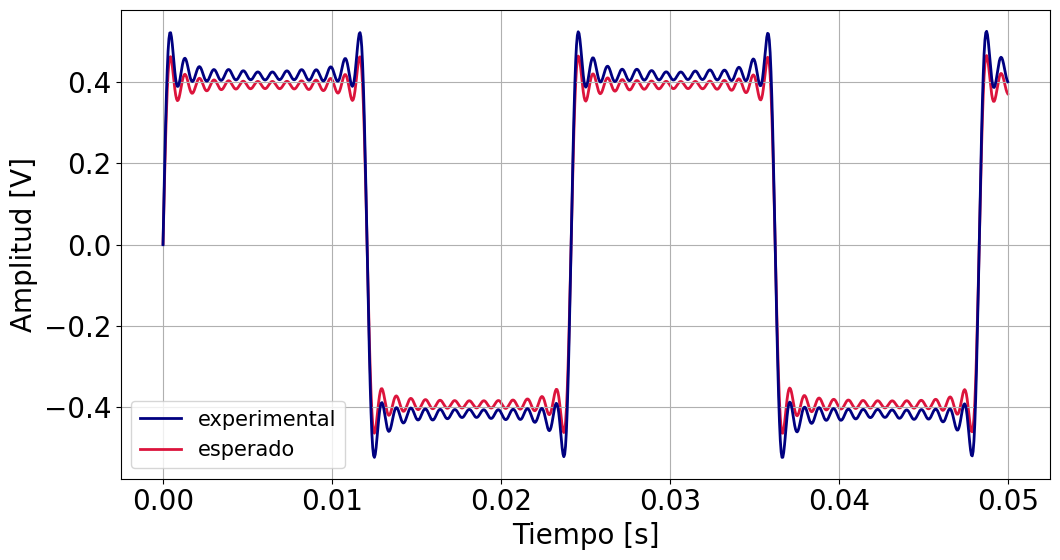

In [11]:
t_s = np.linspace(0,0.05,1000)
signal = fufu_sum(t_s,freq0,amp0)
signal_teo = fufu_sum_teo(t_s,freq0)
plt.plot(t_s,signal,'navy',label='experimental',zorder=2)
plt.plot(t_s,signal_teo/2,'crimson',label='esperado',zorder=1)
plt.grid()
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [V]')
plt.legend(fontsize=15)
plt.savefig('comp_reconstruccion.png')

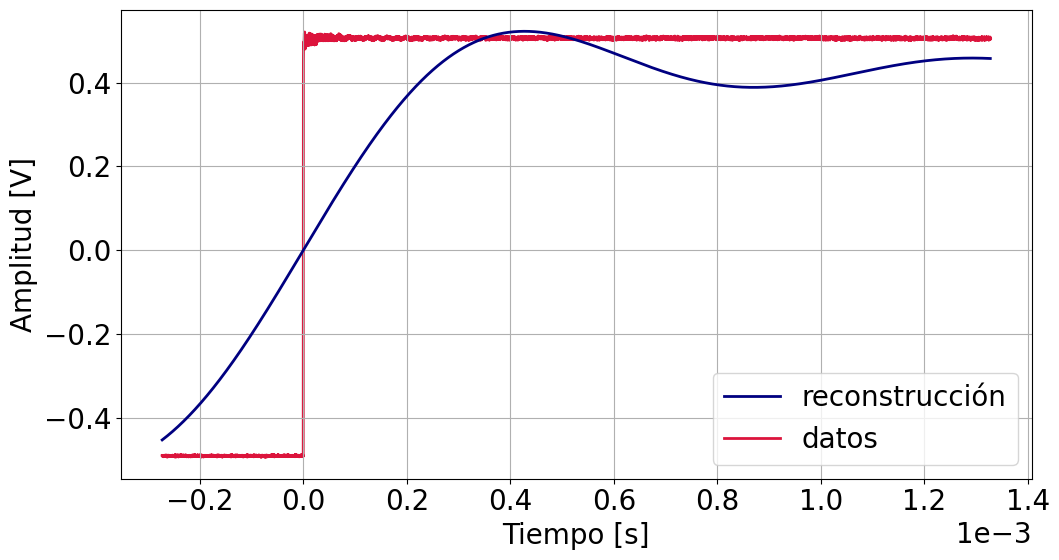

In [13]:
data_comp = np.loadtxt('seke+/cuad piezo 1/TEK00000.CSV',delimiter=',',unpack=True,skiprows=16)
t_comp = data_comp[0]
pulse_comp = data_comp[1]
signal_comp = fufu_sum(t_comp,freq0,amp0)

plt.plot(t_comp,signal_comp,'navy',label='reconstrucción',zorder=2)
plt.plot(t_comp,pulse_comp/20,'crimson',label='datos',zorder=1)
plt.grid()
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [V]')
plt.legend()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.savefig('comp.png')